In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [26]:
def D(p,q):
    return p*np.log2(p/q)+(1-p)*np.log2((1-p)/(1-q))

def Lower_Bound(num_rounds,prob_vec):
    mu_max = np.max(prob_vec)
    constant = 0
    for p in prob_vec:
        if p<mu_max:
            constant += (mu_max-p)/D(p,mu_max)

    return constant*np.log(np.arange(1,num_rounds+1))

In [3]:
def eps_greedy(c,d,K,prob_vec,num_rounds):
    means = np.zeros_like(prob_vec)
    num_plays = np.zeros_like(prob_vec)
    Regret = np.zeros(num_rounds)
    Expected_Regret = np.zeros(num_rounds)
    Plays = np.zeros(num_rounds) 
    for t in range(1,num_rounds+1):
        eps_n = min(1,c*K/((d**2)*t))
        explore = np.random.choice([False,True],p=[1-eps_n,eps_n])
        if explore:
            i = np.random.choice(np.arange(K),p=np.ones(K)/K)
            U = np.random.uniform(0,1,np.size(prob_vec))
            X = np.array(U<=prob_vec,dtype=np.int16)
            means[i] = means[i]*num_plays[i] + X[i]
            num_plays[i] += 1
            means[i] /= num_plays[i]
            Plays[t-1] = i 
            if t==1:
                Regret[t-1] = X[np.argmax(prob_vec)]-X[i]
                Expected_Regret[t-1] = np.max(prob_vec)-prob_vec[i]
            else:
                Regret[t-1] = Regret[t-2] + X[np.argmax(prob_vec)]-X[i]
                Expected_Regret[t-1] = Expected_Regret[t-2] + np.max(prob_vec)-prob_vec[i]

        else:
            i = np.argmax(means)
            U = np.random.uniform(0,1,np.size(prob_vec))
            X = np.array(U<=prob_vec,dtype=np.int16)
            means[i] = means[i]*num_plays[i] + X[i]
            num_plays[i] += 1
            means[i] /= num_plays[i]
            Plays[t-1] = i 
            Regret[t-1] = Regret[t-2] + X[np.argmax(prob_vec)] - X[i]
            Expected_Regret[t-1] = Expected_Regret[t-2] + np.max(prob_vec)-prob_vec[i]   

    return Regret, Expected_Regret, Plays
            

In [35]:
def UCB(K,prob_vec,num_rounds):
    means = np.zeros_like(prob_vec)
    num_plays = np.zeros_like(prob_vec)
    Regret = np.zeros(num_rounds)
    Expected_Regret = np.zeros(num_rounds)
    Plays = np.zeros(num_rounds)
    for t in range(1,num_rounds+1):
        U = np.random.uniform(0,1,K)
        X = np.int32(U<=prob_vec)
        if t<=K:
            i = t % K
        else:
            i = np.argmax(means + np.sqrt(np.minimum(1/4*np.ones_like(means),means-np.square(means)+np.sqrt(2*np.log(t)*np.divide(np.ones_like(num_plays),num_plays)))*np.log(t-1)*np.divide(np.ones_like(num_plays),num_plays)))

        means[i] = means[i]*num_plays[i] + X[i]
        num_plays[i] += 1
        means[i] /= num_plays[i]
        Plays[t-1] = i
        if t==1:
            Regret[t-1] = X[np.argmax(prob_vec)]-X[i]
            Expected_Regret[t-1] = np.max(prob_vec)-prob_vec[i]
        else:
            Regret[t-1] = Regret[t-2] + X[np.argmax(prob_vec)]-X[i]
            Expected_Regret[t-1] = Expected_Regret[t-2]+np.max(prob_vec)-prob_vec[i]

    return Regret, Expected_Regret, Plays

def UCB_upper_bound(num_rounds,prob_vec):
    mu_max = np.max(prob_vec)
    constant_1 = 0
    constant_2 = 0
    for p in prob_vec:
        if p<mu_max:
            constant_1 = 8/(mu_max-p)
            constant_2 = (1+(np.pi**2)/3)*(mu_max-p)
    return constant_1*np.log(np.arange(num_rounds)+1)+constant_2

In [8]:
num_iterations = 100
num_rounds = 10**5

Problem instance 1

In [54]:
p = np.array([0.9,0.6])
c = 0.2
d = 0.3
avg_Regret_eps_greedy_1 = np.zeros(num_rounds)
avg_expected_regret_eps_greedy_1 = np.zeros(num_rounds)
percentage_plays_for_optimal_arm_eps_greedy_1 = np.zeros(num_rounds)
for ctr in range(num_iterations):
    Regret, expected_regret, Plays = eps_greedy(c,d,np.size(p),p,num_rounds)
    avg_Regret_eps_greedy_1 += Regret
    avg_expected_regret_eps_greedy_1 += expected_regret
    percentage_plays_for_optimal_arm_eps_greedy_1 += np.array(Plays==0,dtype=np.int32)

avg_expected_regret_eps_greedy_1 /= num_iterations
avg_Regret_eps_greedy_1 /= num_iterations


In [55]:
p = np.array([0.9,0.6])
c = 0.2
d = 0.3
avg_Regret_UCB_1 = np.zeros(num_rounds)
avg_expected_regret_UCB_1 = np.zeros(num_rounds)
percentage_plays_for_optimal_arm_UCB_1 = np.zeros(num_rounds)
for ctr in range(num_iterations):
    Regret, expected_regret, Plays = UCB(np.size(p),p,num_rounds)
    avg_Regret_UCB_1 += Regret
    avg_expected_regret_UCB_1 += expected_regret
    percentage_plays_for_optimal_arm_UCB_1 += np.array(Plays==0,dtype=np.int32)

avg_expected_regret_UCB_1 /= num_iterations
avg_Regret_UCB_1 /= num_iterations


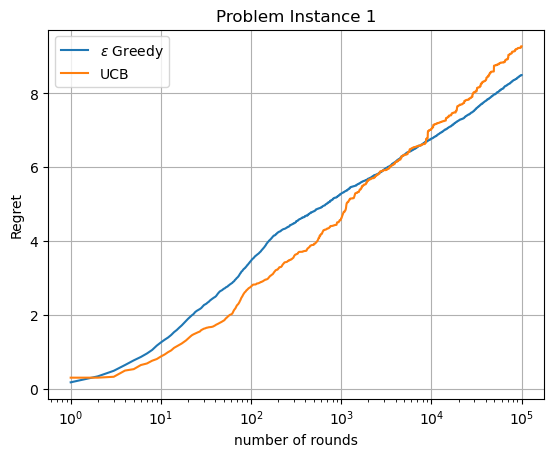

In [65]:
plt.semilogx(np.arange(num_rounds)+1,avg_expected_regret_eps_greedy_1)
plt.semilogx(np.arange(num_rounds)+1,avg_expected_regret_UCB_1)
plt.legend([r'$\epsilon$ Greedy','UCB'])
plt.xlabel('number of rounds')
plt.ylabel('Regret')
plt.grid(True)
plt.title('Problem Instance 1')
plt.savefig('./Problem_instance_1.jpg')
plt.show()

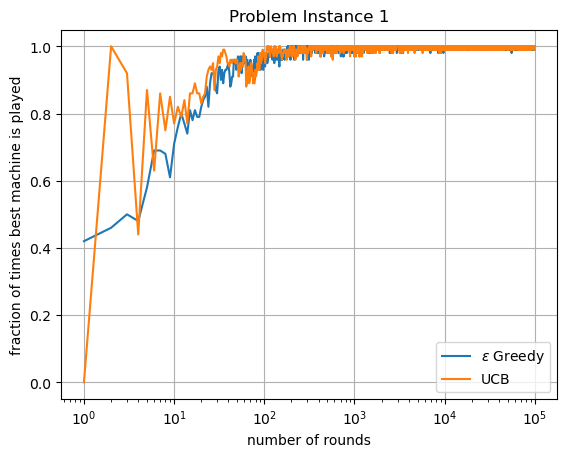

In [84]:
plt.semilogx(np.arange(num_rounds)+1,percentage_plays_for_optimal_arm_eps_greedy_1/100)
plt.semilogx(np.arange(num_rounds)+1,percentage_plays_for_optimal_arm_UCB_1/100)
plt.legend([r'$\epsilon$ Greedy','UCB'])
plt.xlabel('number of rounds')
plt.ylabel('fraction of times best machine is played')
plt.grid(True)
plt.title('Problem Instance 1')
plt.show()

Problem instance 2

In [68]:
p = np.array([0.9,0.8])
c = 0.1
d = 0.1
avg_Regret_eps_greedy_2 = np.zeros(num_rounds)
avg_expected_regret_eps_greedy_2 = np.zeros(num_rounds)
percentage_plays_for_optimal_arm_eps_greedy_2 = np.zeros(num_rounds)
for ctr in range(num_iterations):
    Regret, expected_regret, Plays = eps_greedy(c,d,np.size(p),p,num_rounds)
    avg_Regret_eps_greedy_2 += Regret
    avg_expected_regret_eps_greedy_2 += expected_regret
    percentage_plays_for_optimal_arm_eps_greedy_2 += np.array(Plays==0,dtype=np.int32)

avg_expected_regret_eps_greedy_2 /= num_iterations
avg_Regret_eps_greedy_2 /= num_iterations

In [34]:
p = np.array([0.9,0.8])
avg_Regret_UCB_2 = np.zeros(num_rounds)
avg_expected_regret_UCB_2 = np.zeros(num_rounds)
percentage_plays_for_optimal_arm_UCB_2 = np.zeros(num_rounds)
for ctr in range(num_iterations):
    Regret, expected_regret, Plays = UCB(np.size(p),p,num_rounds)
    avg_Regret_UCB_2 += Regret
    avg_expected_regret_UCB_2 += expected_regret
    percentage_plays_for_optimal_arm_UCB_2 += np.array(Plays==0,dtype=np.int32)

avg_expected_regret_UCB_2 /= num_iterations
avg_Regret_UCB_2 /= num_iterations


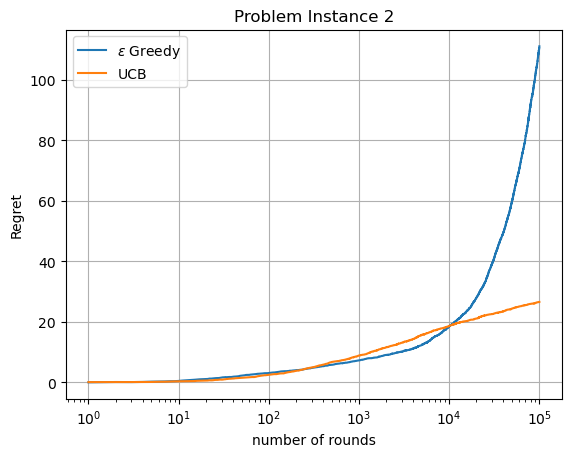

In [72]:
plt.semilogx(np.arange(num_rounds)+1,avg_Regret_eps_greedy_2)
plt.semilogx(np.arange(num_rounds)+1,avg_Regret_UCB_2)
plt.legend([r'$\epsilon$ Greedy','UCB'])
plt.xlabel('number of rounds')
plt.ylabel('Regret')
plt.grid(True)
plt.title("Problem Instance 2")
plt.savefig("./problem_instance_2.jpg")
plt.show()

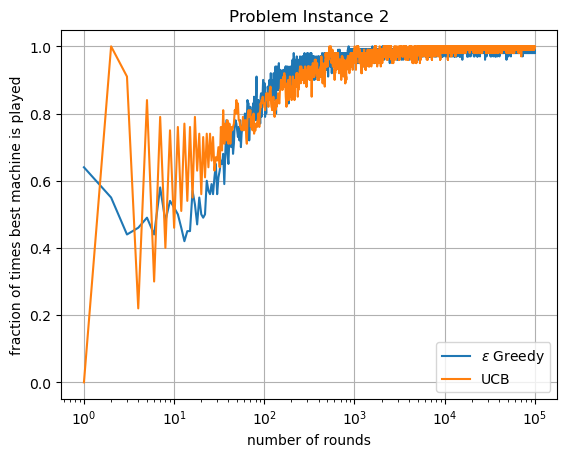

In [83]:
plt.semilogx(np.arange(num_rounds)+1,percentage_plays_for_optimal_arm_eps_greedy_2/100)
plt.semilogx(np.arange(num_rounds)+1,percentage_plays_for_optimal_arm_UCB_2/100)
plt.legend([r'$\epsilon$ Greedy','UCB'])
plt.xlabel('number of rounds')
plt.ylabel('fraction of times best machine is played')
plt.grid(True)
plt.title('Problem Instance 2')
plt.show()

Problem Instance 11

In [16]:
p_11 = np.array([0.9, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6])
c = 0.15
d = 0.3
avg_Regret_eps_greedy_11 = np.zeros(num_rounds)
avg_expected_regret_eps_greedy_11 = np.zeros(num_rounds)
percentage_plays_for_optimal_arm_eps_greedy_11 = np.zeros(num_rounds)
for ctr in range(num_iterations):
    Regret, expected_regret, Plays = eps_greedy(c,d,np.size(p_11),p_11,num_rounds)
    avg_Regret_eps_greedy_11 += Regret
    avg_expected_regret_eps_greedy_11 += expected_regret
    percentage_plays_for_optimal_arm_eps_greedy_11 += np.array(Plays==0,dtype=np.int32)

avg_expected_regret_eps_greedy_11 /= num_iterations
avg_Regret_eps_greedy_11 /= num_iterations


In [20]:
p_11 = np.array([0.9, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6])

avg_Regret_UCB_11 = np.zeros(num_rounds)
avg_expected_regret_UCB_11 = np.zeros(num_rounds)
percentage_plays_for_optimal_arm_UCB_11 = np.zeros(num_rounds)
for ctr in range(num_iterations):
    Regret, expected_regret, Plays = eps_greedy(c,d,np.size(p_11),p_11,num_rounds)
    avg_Regret_UCB_11 += Regret
    avg_expected_regret_UCB_11 += expected_regret
    percentage_plays_for_optimal_arm_UCB_11 += np.array(Plays==0,dtype=np.int32)

avg_expected_regret_UCB_11 /= num_iterations
avg_Regret_UCB_11 /= num_iterations

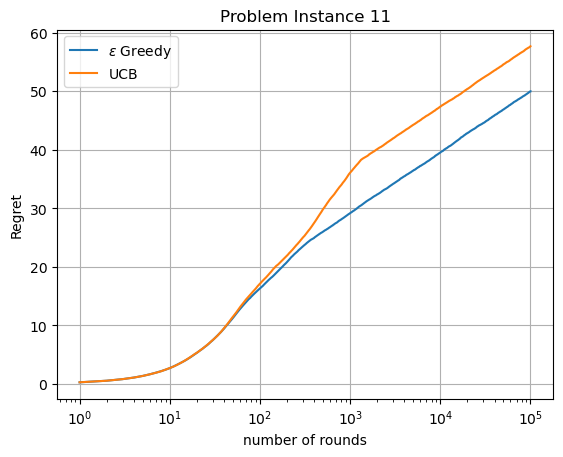

In [67]:
plt.semilogx(np.arange(num_rounds)+1,avg_expected_regret_eps_greedy_11)
plt.semilogx(np.arange(num_rounds)+1,avg_expected_regret_UCB_11)
plt.legend([r'$\epsilon$ Greedy','UCB'])
plt.xlabel('number of rounds')
plt.ylabel('Regret')
plt.grid(True)
plt.title("Problem Instance 11")
plt.savefig('./problem_instance_11.jpg')
plt.show()

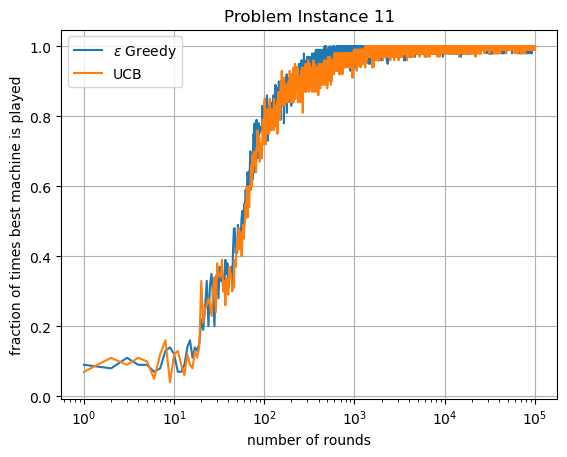

In [82]:
plt.semilogx(np.arange(num_rounds)+1,percentage_plays_for_optimal_arm_eps_greedy_11/100)
plt.semilogx(np.arange(num_rounds)+1,percentage_plays_for_optimal_arm_UCB_11/100)
plt.legend([r'$\epsilon$ Greedy','UCB'])
plt.xlabel('number of rounds')
plt.ylabel('fraction of times best machine is played')
plt.grid(True)
plt.title('Problem Instance 11')
plt.show()

Problem Instance 12

In [78]:
p_12 = [0.9, 0.8, 0.8, 0.8, 0.7, 0.7, 0.7, 0.6, 0.6, 0.6]
c = 0.1
d = 0.1
avg_Regret_eps_greedy_12 = np.zeros(num_rounds)
avg_expected_regret_eps_greedy_12 = np.zeros(num_rounds)
percentage_plays_for_optimal_arm_eps_greedy_12 = np.zeros(num_rounds)
for ctr in range(num_iterations):
    Regret, expected_regret, Plays = eps_greedy(c,d,np.size(p_12),p_12,num_rounds)
    avg_Regret_eps_greedy_12 += Regret
    avg_expected_regret_eps_greedy_12 += expected_regret
    percentage_plays_for_optimal_arm_eps_greedy_12 += np.array(Plays==0,dtype=np.int32)

avg_expected_regret_eps_greedy_12 /= num_iterations
avg_Regret_eps_greedy_12 /= num_iterations

In [79]:
p_12 = [0.9, 0.8, 0.8, 0.8, 0.7, 0.7, 0.7, 0.6, 0.6, 0.6]
c = 0.1
d = 0.1
avg_Regret_UCB_12 = np.zeros(num_rounds)
avg_expected_regret_UCB_12 = np.zeros(num_rounds)
percentage_plays_for_optimal_arm_UCB_12 = np.zeros(num_rounds)
for ctr in range(num_iterations):
    Regret, expected_regret, Plays = eps_greedy(c,d,np.size(p_12),p_12,num_rounds)
    avg_Regret_UCB_12 += Regret
    avg_expected_regret_UCB_12 += expected_regret
    percentage_plays_for_optimal_arm_UCB_12 += np.array(Plays==0,dtype=np.int32)

avg_expected_regret_UCB_12 /= num_iterations
avg_Regret_UCB_12 /= num_iterations

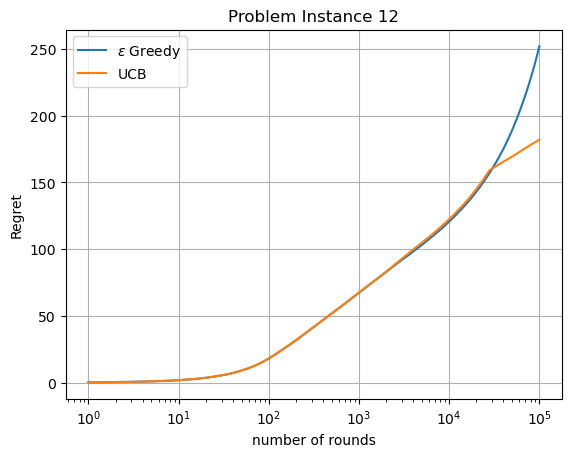

In [80]:
plt.semilogx(np.arange(num_rounds)+1,avg_expected_regret_eps_greedy_12)
plt.semilogx(np.arange(num_rounds)+1,avg_expected_regret_UCB_12)
plt.legend([r'$\epsilon$ Greedy','UCB'])
plt.xlabel('number of rounds')
plt.ylabel('Regret')
plt.grid(True)
plt.title("Problem Instance 12")
plt.savefig('./problem_instance_12.jpg')
plt.show()

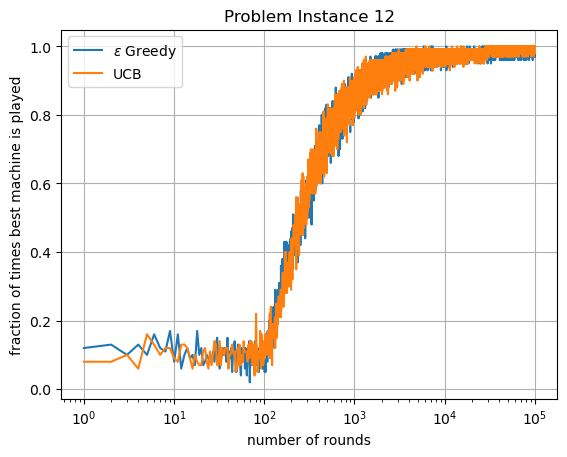

In [81]:
plt.semilogx(np.arange(num_rounds)+1,percentage_plays_for_optimal_arm_eps_greedy_12/100)
plt.semilogx(np.arange(num_rounds)+1,percentage_plays_for_optimal_arm_UCB_12/100)
plt.legend([r'$\epsilon$ Greedy','UCB'])
plt.xlabel('number of rounds')
plt.ylabel('fraction of times best machine is played')
plt.grid(True)
plt.title('Problem Instance 12')
plt.show()